In [1]:
%load_ext autoreload
%autoreload 2

import sys  # noqa

from mabwiser.mab import LearningPolicy  # noqa
import matplotlib.pyplot as plt  # noqa
import pandas as pd  # noqa
import seaborn as sns  # noqa

pd.set_option("display.max_rows", 300)  # Set the number of rows to display to 100

sys.path.append("..")

from backend.llm.mab_ranker import MultiArmedBanditRanker  # noqa: E402
from backend.llm.ranking import Battle, ChoixRanker, ChoixRankerConfIntervals  # noqa: E402
from backend.llm.routing import RankedRouter, RoutingPolicy  # noqa: E402

In [2]:
# Load LS data; see ls_elo_comparison.ipynb
df = pd.read_csv("../../lmsys-arena-human-preference-55k/train.csv")


# The original LS code references a "winner" column, but this is not in the dataset, add it here.
def get_winner(row):
    if row["winner_tie"] == 1:
        return "tie"
    elif row["winner_model_a"] == 1:
        return "model_a"
    elif row["winner_model_b"] == 1:
        return "model_b"
    raise ValueError(f"Unknown winner: {row['winner_model_a']}, {row['winner_model_b']}, {row['winner_tie']}")


df["winner"] = df.apply(get_winner, axis=1)
df.head(3)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,model_a
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,model_b
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,tie


In [3]:
def get_models(df: pd.DataFrame) -> list[str]:
    return list(set(df.model_a.unique()) | set(df.model_b.unique()))


def binarize(arm, reward):
    return reward >= 0.5


ranker = MultiArmedBanditRanker(
    models=get_models(df),
    # learning_policy=LearningPolicy.ThompsonSampling(binarizer=binarize),
    learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
)

arm_df = pd.DataFrame()
for i, row in df.iterrows():
    result = 0.5 if row["winner_tie"] else (1 if row["winner"] == "model_a" else 0)
    ranker.update(row.model_a, row.model_b, result)
    if i % 2500 == 0 and i > 0:
        ranks = ranker.ranks()
        arm_df_i = pd.DataFrame(list(ranks.items()), columns=["model", f"rank_{i}"])
        if arm_df.empty:
            arm_df = arm_df_i
        else:
            arm_df = pd.merge(arm_df, arm_df_i, on="model", how="inner")

arm_df.head(3)

,model,rank_2500,rank_5000,rank_7500,rank_10000,rank_12500,rank_15000,rank_17500,rank_20000,rank_22500,...,rank_32500,rank_35000,rank_37500,rank_40000,rank_42500,rank_45000,rank_47500,rank_50000,rank_52500,rank_55000
0,gpt-4-0125-preview,0.64000,0.220360,0.696970,0.659420,0.661417,0.661667,0.662281,0.676020,0.672949,...,0.672334,0.854716,0.676000,0.675539,0.673835,0.668345,0.668962,0.671343,0.667932,0.667120
1,alpaca-13b,0.43662,0.184372,0.413636,0.410714,0.423193,0.414286,0.402870,0.397638,0.390681,...,0.391960,0.144677,0.397394,0.395939,0.393474,0.393116,0.396791,0.400735,0.406859,0.404319
2,chatglm2-6b,0.28000,0.175906,0.216216,0.245283,0.251852,0.245455,0.253927,0.261574,0.261506,...,0.271341,0.179241,0.280749,0.281095,0.288551,0.279736,0.278481,0.276104,0.281676,0.283457


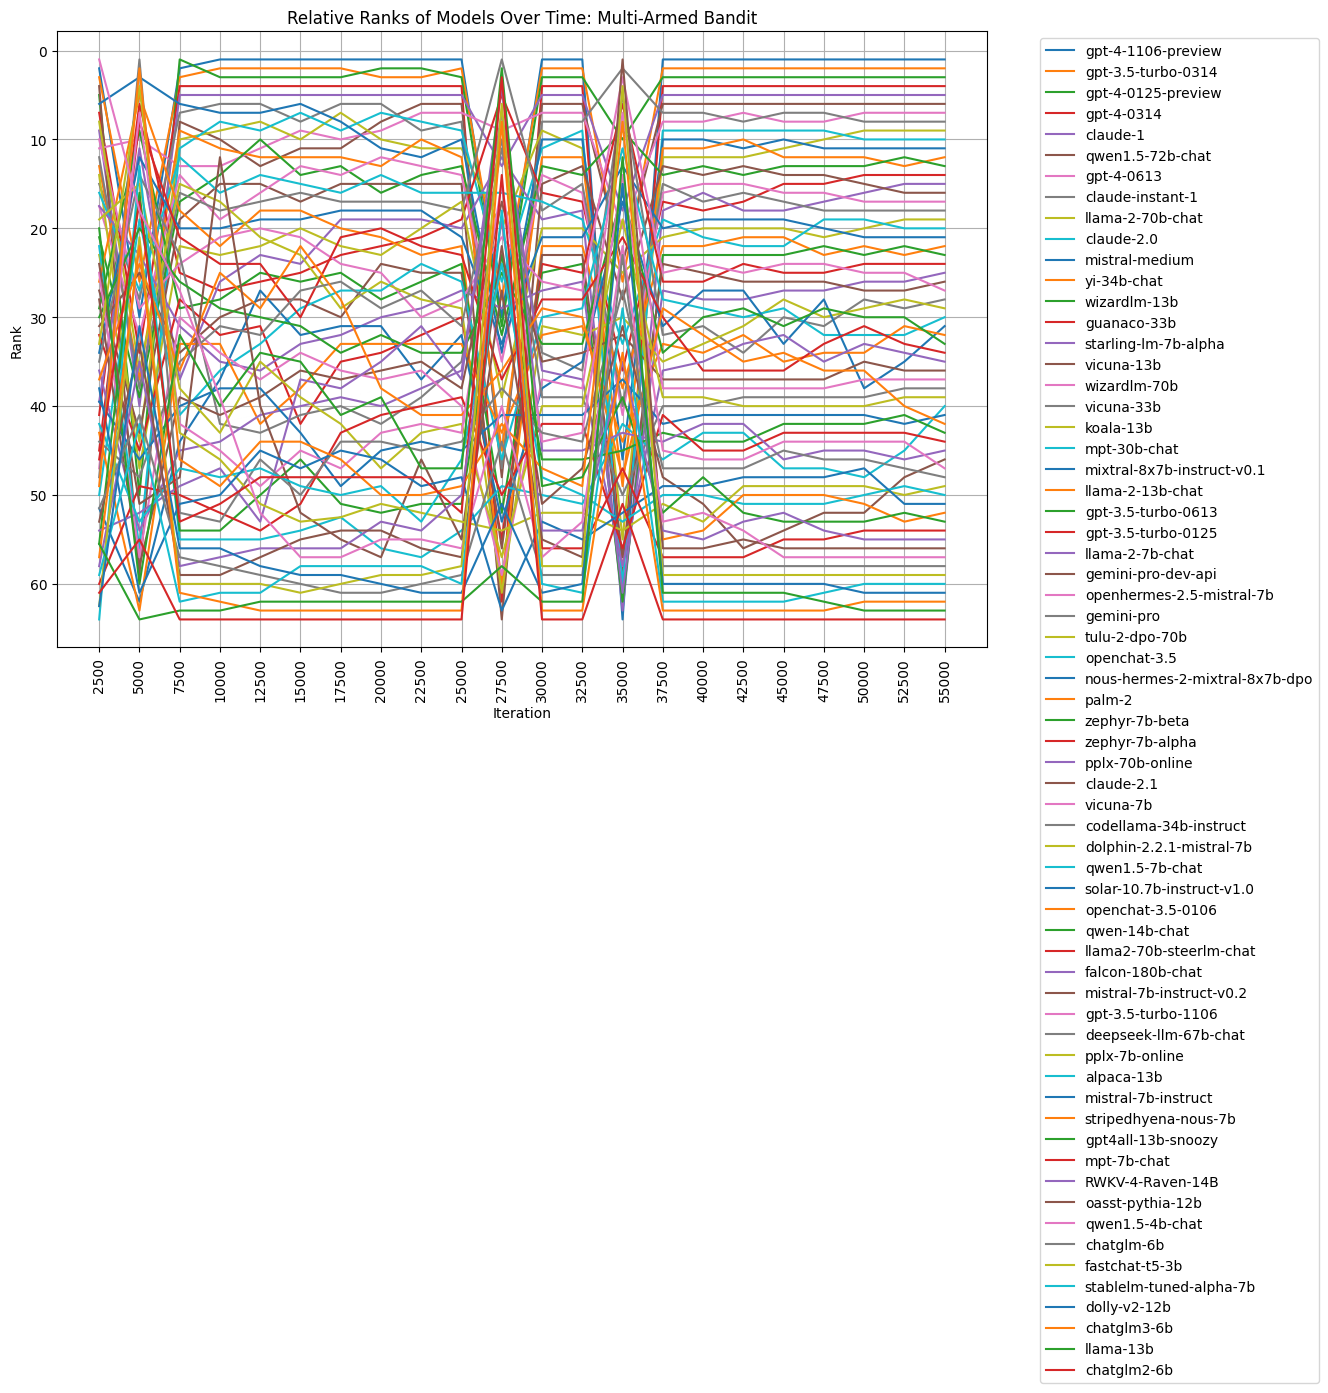

In [4]:
def plot_ranked_df(model_df: pd.DataFrame, title: str):
    rank_columns = [col for col in model_df.columns if col.startswith("rank_")]
    rank_columns_sorted = sorted(rank_columns, key=lambda x: int(x.split("_")[1]))

    # Calculate the ranks of the arms for each expectation column in ascending order
    rank_df = model_df.set_index("model")[rank_columns_sorted].rank(ascending=False)

    # Sort arms by their final rank in ascending order
    final_ranks = rank_df[rank_columns_sorted[-1]].sort_values().index

    # Plot the ranks over time using seaborn
    plt.figure(figsize=(12, 8))
    for arm in final_ranks:
        sns.lineplot(data=rank_df.loc[arm], label=arm)

    plt.xlabel("Iteration")
    plt.ylabel("Rank")
    plt.title(f"Relative Ranks of Models Over Time: {title}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.xticks(
        ticks=range(len(rank_columns_sorted)),
        labels=[int(col.split("_")[1]) for col in rank_columns_sorted],
        rotation=90,
    )
    plt.gca().invert_yaxis()  # Invert the y-axis to have rank 1 at the top
    plt.show()


plot_ranked_df(arm_df, "Multi-Armed Bandit")

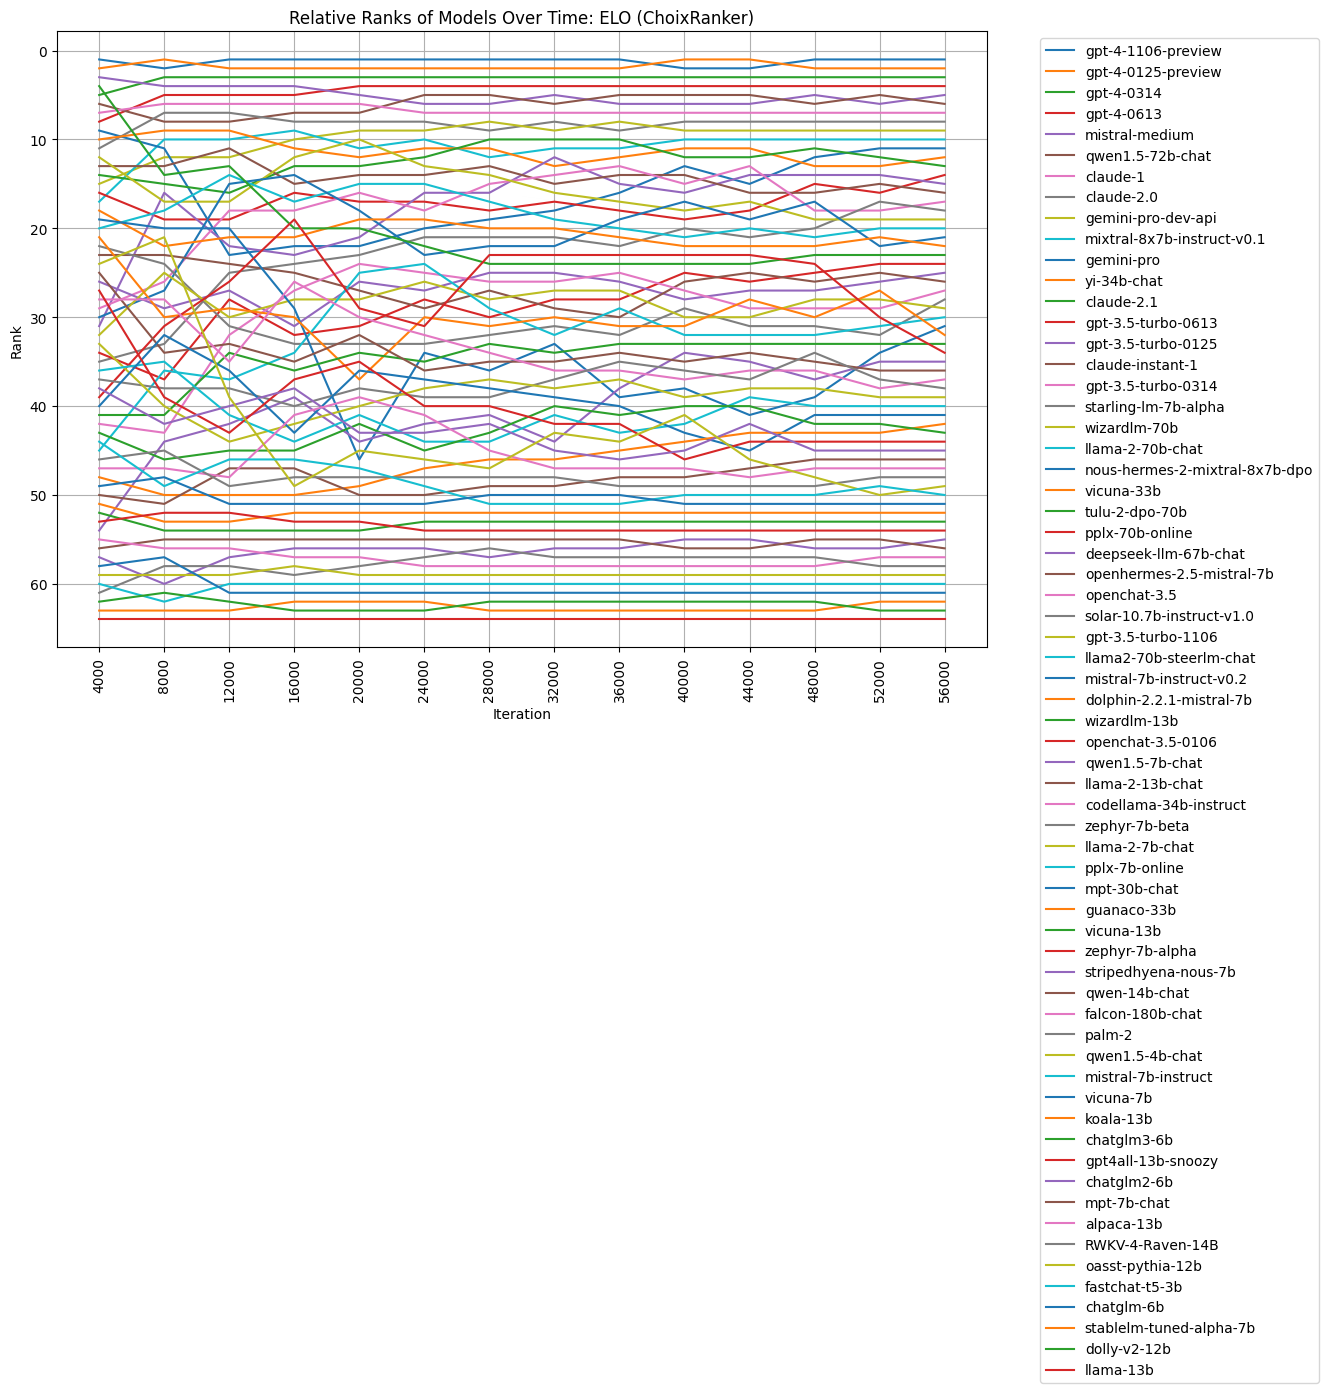

In [5]:
# Convert the dataset to a list of battles, our internal representation.
def row_to_battle(row):
    if row.winner_model_b == 1:
        result = 0
    elif row.winner_model_a == 1:
        result = 1
    elif row.winner_tie == 1:
        result = 0.5
    else:
        raise ValueError(f"Unknown winner: {row}")
    return Battle(row.model_a, row.model_b, result)


battles = [row_to_battle(row) for _, row in df.iterrows()]

elo_rank_df = pd.DataFrame()
for i in range(4000, len(battles), 4000):
    models = get_models(df.head(i))
    ranker = ChoixRanker(models, battles=battles[:i], choix_ranker_algorithm="ilsr_pairwise")
    leaderboard = ranker.leaderboard()
    leaderboard_df = pd.DataFrame([item.to_dict() for item in leaderboard])
    leaderboard_df.rename(columns={"rank": f"rank_{i}"}, inplace=True)
    leaderboard_df.drop(columns=["annotation"], inplace=True)
    if elo_rank_df.empty:
        elo_rank_df = leaderboard_df
    else:
        elo_rank_df = pd.merge(elo_rank_df, leaderboard_df, on="model", how="inner")

plot_ranked_df(elo_rank_df, "ELO (ChoixRanker)")

In [6]:
from collections import Counter

router = RankedRouter(models, ranker)

prob_counts = Counter(
    [tuple(router.select_models(2, policy=RoutingPolicy.PROPORTIONAL)) for _ in range(1000)]
).most_common(10)
prob_counts

[(('openchat-3.5', 'gpt-4-1106-preview'), 4),
 (('llama-2-7b-chat', 'mixtral-8x7b-instruct-v0.1'), 4),
 (('guanaco-33b', 'qwen1.5-72b-chat'), 3),
 (('gpt-3.5-turbo-0613', 'zephyr-7b-alpha'), 3),
 (('gpt-4-1106-preview', 'claude-2.0'), 3),
 (('llama-2-70b-chat', 'vicuna-33b'), 3),
 (('gpt-4-0613', 'claude-1'), 3),
 (('yi-34b-chat', 'mistral-medium'), 3),
 (('gpt-4-0125-preview', 'claude-2.0'), 3),
 (('claude-2.0', 'gpt-4-0314'), 3)]

In [13]:
ranker = ChoixRankerConfIntervals(models, battles=battles, choix_ranker_algorithm="lsr_pairwise")
sorted(ranker.leaderboard(), key=lambda x: x.rank.value, reverse=True)[:8]

[RankedModel(model='gpt-4-1106-preview', rank=AnnotatedFloat(value=0.9366232978954361, annotation='Wins: 4073, Losses: 1287, Ties: 2027 (0.890 to 0.982)')),
 RankedModel(model='gpt-4-0125-preview', rank=AnnotatedFloat(value=0.9285280282660212, annotation='Wins: 596, Losses: 202, Ties: 362 (0.871 to 0.993)')),
 RankedModel(model='gpt-4-0314', rank=AnnotatedFloat(value=0.6096491152989076, annotation='Wins: 1993, Losses: 930, Ties: 1199 (0.567 to 0.654)')),
 RankedModel(model='gpt-4-0613', rank=AnnotatedFloat(value=0.5531794165353885, annotation='Wins: 2450, Losses: 1856, Ties: 1859 (0.510 to 0.587)')),
 RankedModel(model='qwen1.5-72b-chat', rank=AnnotatedFloat(value=0.4999468119878442, annotation='Wins: 215, Losses: 155, Ties: 181 (0.405 to 0.581)')),
 RankedModel(model='mistral-medium', rank=AnnotatedFloat(value=0.48521404774931015, annotation='Wins: 1219, Losses: 1012, Ties: 1084 (0.439 to 0.531)')),
 RankedModel(model='claude-1', rank=AnnotatedFloat(value=0.4332492551908504, annotatio

In [8]:
ranker = ChoixRankerConfIntervals(models, battles=(), choix_ranker_algorithm="lsr_pairwise")
gemini_ranks_over_time = []

for i in range(len(battles)):
    ranker.update(battles[i].model_a, battles[i].model_b, battles[i].result_a)
    if i > 0 and i % 1000 == 0:
        ranks = ranker.ranks_conf_intervals()
        gemini_ranks = {k: v for k, v in ranks.items() if "gemini" in k}
        for model, (rank, (lower, upper)) in gemini_ranks.items():
            gemini_ranks_over_time.append(
                {
                    "iteration": i,
                    "model": model,
                    "rank": rank,
                    "lower": lower,
                    "upper": upper,
                },
            )

gemini_ranks_df = pd.DataFrame(gemini_ranks_over_time)
gemini_ranks_df["iteration"] = gemini_ranks_df["iteration"].astype(int)
gemini_ranks_df = gemini_ranks_df.sort_values(["iteration", "model"])
gemini_ranks_df.head(6)

,iteration,model,rank,lower,upper
0,1000,gemini-pro,0.221637,-0.167814,0.726376
1,1000,gemini-pro-dev-api,0.303731,-0.057553,0.723844
2,2000,gemini-pro,0.276239,-0.047357,0.577758
3,2000,gemini-pro-dev-api,0.339030,-0.002217,0.576750
4,3000,gemini-pro,0.348594,-0.005507,0.685258
5,3000,gemini-pro-dev-api,0.301130,-0.037284,0.691445


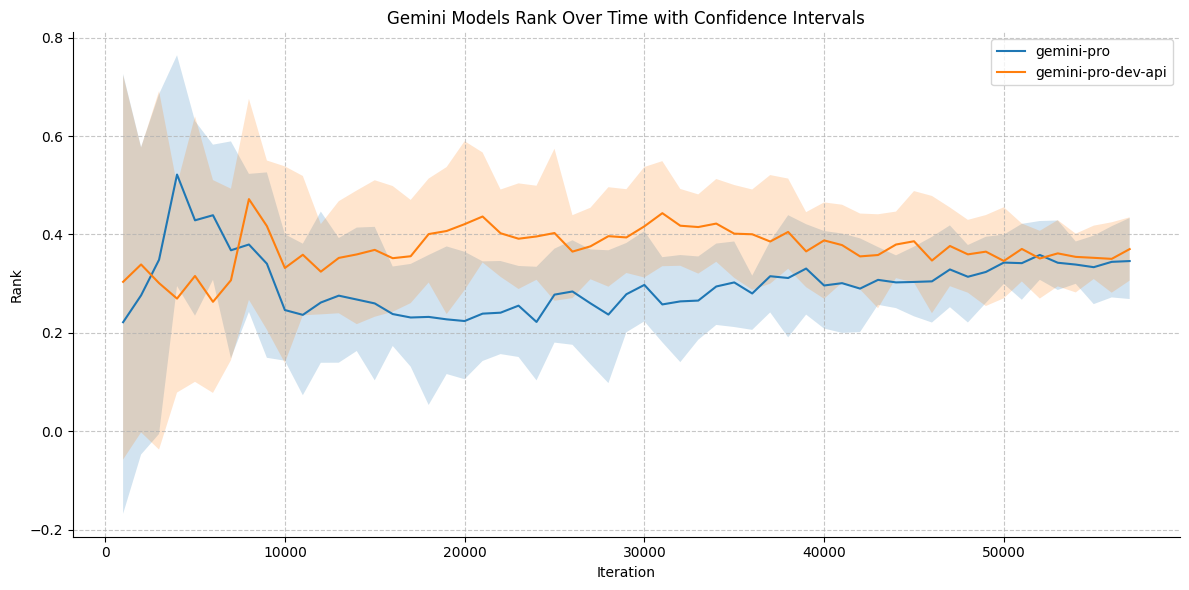

In [9]:
plt.figure(figsize=(12, 6))

for model in gemini_ranks_df["model"].unique():
    model_data = gemini_ranks_df[gemini_ranks_df["model"] == model]
    plt.plot(model_data["iteration"], model_data["rank"], label=model)
    plt.fill_between(model_data["iteration"], model_data["lower"], model_data["upper"], alpha=0.2)

plt.xlabel("Iteration")
plt.ylabel("Rank")
plt.title("Gemini Models Rank Over Time with Confidence Intervals")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

sns.despine()
plt.tight_layout()
plt.show()

In [10]:
gemini_ranks_df.tail(6)

,iteration,model,rank,lower,upper
108,55000,gemini-pro,0.333528,0.258438,0.397589
109,55000,gemini-pro-dev-api,0.352534,0.309400,0.417952
110,56000,gemini-pro,0.344358,0.272038,0.416797
111,56000,gemini-pro-dev-api,0.350429,0.281619,0.424791
112,57000,gemini-pro,0.345975,0.268778,0.433507
113,57000,gemini-pro-dev-api,0.370290,0.306253,0.434859
